In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# load data and show some instances per domain

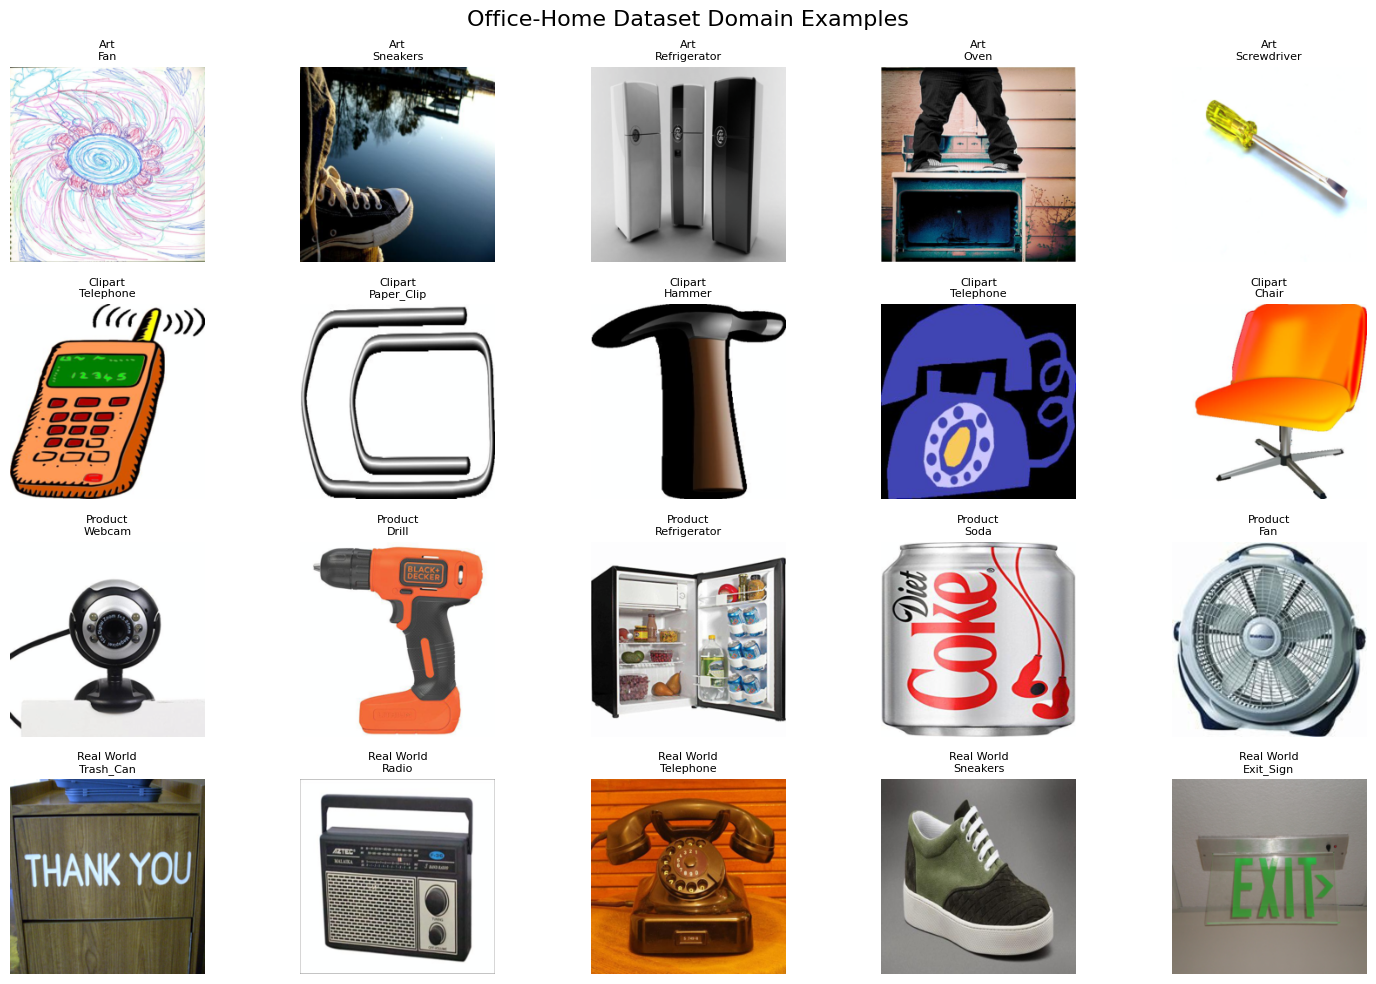

In [2]:
# 定义预处理（不包含随机增强，以便固定展示）
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # 统一调整为224x224
    transforms.ToTensor(),                  # 转为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet标准化
])

# Office-Home的四个领域
domains = ["Art", "Clipart", "Product", "Real World"]
num_samples = 5  # 每个领域展示5张图片

# 创建画布
fig, axes = plt.subplots(len(domains), num_samples, figsize=(15, 10))
plt.suptitle("Office-Home Dataset Domain Examples", fontsize=16)

# 遍历每个领域
for row, domain in enumerate(domains):
    # 加载数据
    domain_path = os.path.join("OfficeHomeDataset_10072016", domain)
    domain_data = datasets.ImageFolder(root=domain_path, transform=transform)
    
    # 随机选择5张图片
    indices = np.random.choice(len(domain_data), num_samples, replace=False)
    images = [domain_data[i][0] for i in indices]#元组的第一个元素是图像数据（通常是一个 torch.Tensor 类型的对象）
    labels = [domain_data.classes[domain_data[i][1]] for i in indices]#第二个元素是该图像对应的类别标签的索引
    
    # 反归一化并显示图片
    for col, (img, label) in enumerate(zip(images, labels)):
        img = img.numpy().transpose((1, 2, 0))  # 将 (C, H, W) 格式转换为 (H, W, C) 格式
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)  # 反归一化
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{domain}\n{label}", fontsize=8)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

模型初始化

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50, self).__init__()
        self.resnet50 = models.resnet50(weights="DEFAULT")
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)#fc.in_features固定为2048​​：由ResNet50最后一个卷积层的通道数决定，与输入尺寸无关。

    def forward(self, x):
        return self.resnet50(x)


训练过程和测试过程


In [5]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)#交叉熵无需手动 softmax，自动匹配形状
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

训练和测试循环

In [6]:
def run_training(model, train_loader, test_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # 绘制损失和准确率曲线
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_loss, label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

实现三个迁移任务

Art → Real-World

d:\conda2024\envs\cs231n\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\conda2024\envs\cs231n\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 4.2105, Train Acc: 0.0433, Test Acc: 0.0312
Epoch [2/100], Train Loss: 4.0639, Train Acc: 0.0453, Test Acc: 0.0558
Epoch [3/100], Train Loss: 3.9768, Train Acc: 0.0643, Test Acc: 0.0239
Epoch [4/100], Train Loss: 3.9784, Train Acc: 0.0684, Test Acc: 0.0627
Epoch [5/100], Train Loss: 3.9234, Train Acc: 0.0750, Test Acc: 0.0663
Epoch [6/100], Train Loss: 3.9289, Train Acc: 0.0738, Test Acc: 0.0466
Epoch [7/100], Train Loss: 3.8887, Train Acc: 0.0721, Test Acc: 0.0643
Epoch [8/100], Train Loss: 3.8521, Train Acc: 0.0803, Test Acc: 0.0647
Epoch [9/100], Train Loss: 3.8090, Train Acc: 0.0915, Test Acc: 0.0691
Epoch [10/100], Train Loss: 3.8015, Train Acc: 0.0960, Test Acc: 0.0783
Epoch [11/100], Train Loss: 3.7587, Train Acc: 0.0948, Test Acc: 0.0762
Epoch [12/100], Train Loss: 3.7289, Train Acc: 0.0927, Test Acc: 0.0753
Epoch [13/100], Train Loss: 3.6952, Train Acc: 0.1034, Test Acc: 0.0932
Epoch [14/100], Train Loss: 3.6900, Train Acc: 0.1108, Test Acc: 0.0888
E

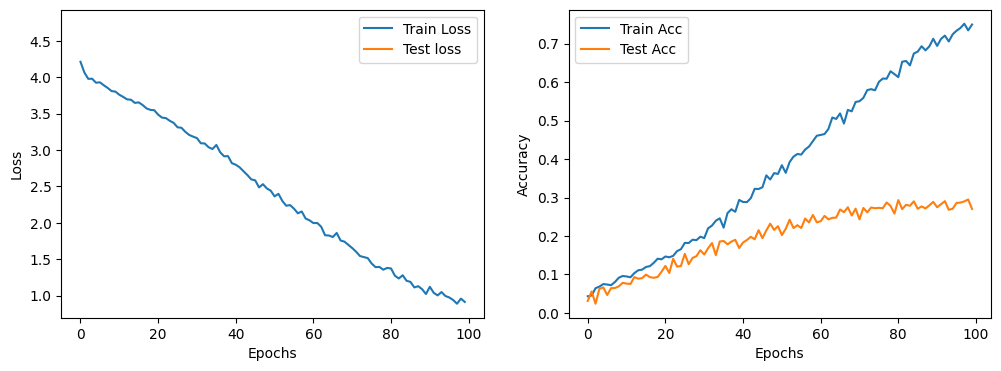

In [ ]:
def DomainAdaptation(source_domain, target_domain):
    # 数据集路径 ImageFolder返回dataset数据类型
    train_dataset = datasets.ImageFolder(root=f'OfficeHomeDataset_10072016/{source_domain}', transform=train_transform)
    test_dataset = datasets.ImageFolder(root=f'OfficeHomeDataset_10072016/{target_domain}', transform=test_transform)

    # 数据加载器 DataLoader批处理生成器​​
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)# ​​可迭代的批处理数据生成器
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    num_classes = len(train_dataset.classes)

    #重新初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomResNet50(num_classes).to(device)

    #优化器和损失函数:使用Adam优化器和交叉熵损失函数
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    num_epochs=100
    run_training(model,train_loader,test_loader,criterion,optimizer,device,num_epochs)

# 数据增强
train_transform = transforms.Compose([
    transforms.Resize(256),                  # Resize to 256x256
    transforms.CenterCrop(224),       # Random crop with resize
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.ColorJitter(0.4, 0.4, 0.4),   # Color jitter
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.470, 0.447, 0.408],  # ImageNet normalization
                         std=[0.226, 0.220, 0.223])
])

test_transform = transforms.Compose([
    transforms.Resize(256),                  # Resize to 256x256
    transforms.CenterCrop(224),       # Random crop with resize
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
source_domain = 'Art'  # Choose source domain
target_domain = 'Real World'  # Choose target domain

DomainAdaptation(source_domain,target_domain)


 Product → Clipart

In [ ]:
DomainAdaptation('Art','Real World')

Clipart → Art

In [ ]:
DomainAdaptation('Clipart','Art')